# Header
Author: Wang Dong  
Email: wang0dong@gmail.com, dwang2014@my.fit.edu  
Date: 12/01/2023  
Reference:  
https://colab.research.google.com/github/jakevdp/PythonDataScienceHandbook/blob/master/notebooks/05.09-Principal-Component-Analysis.ipynb#scrollTo=iqHBrCDSLVaY
https://github.com/msrepo/statistical_shape_model.git

In [1]:
'''
Libraries 
'''
import os
import numpy as np
import scipy.linalg 
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from scipy import interpolate
from sklearn.decomposition import PCA

DATASET = 'HAND'

In [2]:
'''
Functions
'''
# input shape file process
def skip_comments(fp):
    while True:
        last_pos = fp.tell()
        line = fp.readline()
        if not line.strip().startswith('#') and  line.strip():
           break
    fp.seek(last_pos)
    
def getxy_selective(line):
    points = line.split()
    return [float(points[2]), float(points[3])]

# input shape file process
def getxy(line):
    points = line.split()
    return [ float(point) for point in points]

# input shape file process
def readPoints(filepath, filename,getxy=getxy):
    with open(os.path.join(filepath,filename)) as fp:
        skip_comments(fp)
        num_points = int(fp.readline())
        skip_comments(fp)
        points = [getxy(fp.readline()) for i in range(num_points)]
#         print(points)
    return points

# input image file process
def imgname_from_segfilename(filepath, filename):
    return os.path.join(filepath,filename.split(sep='.')[0]+'.bmp')

# input image file process
def readSegmentations(filepath,getxy = getxy,extension = 'asf'):

    segmentationlist = [ readPoints(filepath,file,getxy) for file in os.listdir(filepath)
                            if file.endswith(extension)]
    return segmentationlist

# input image file process
def getImageWH(filename):
    img = mpimg.imread(filename)
    return img.shape


def interp(points, closed_curve = False,k_=3,s_=0):
    if closed_curve:
        points = np.vstack((points,points[0]))
    tck, u = interpolate.splprep([points[:,0],points[:,1]], k=k_,s=s_)
    if closed_curve:
        u = np.linspace(0,1,num = 150,endpoint = True)
    else:
        u = np.linspace(0,1,num = 150,endpoint = False)
    interp_inner = interpolate.splev(u, tck)
    return interp_inner

def showInterp(interp_points,W=256,H=256,marker = 'r'):
#     plt.plot(interp_points[0],interp_points[1],marker)
    plt.plot(interp_points[0]*W,interp_points[1]*H,marker)
    plt.axis('off')

def get_centroids(points):
    """ obtain centroid of LV cardiac dataset which consists of two
    circles each containing 33 points """
    c1 = np.mean(points[:33],axis = 0)
    c2 = np.mean(points[33:],axis = 0) 
    return c1,c2

def unmake_1d(hand):
    return np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)])
#     print(np.array([ [hand[i], hand[i+56]] for i in range(0,hand.shape[0]//2)]))

def make_1d(hand):
    return np.concatenate((hand[:,0],hand[:,1])).reshape(-1)

def showImg(filename,show = False):
    plt.imshow(mpimg.imread(filename))
    plt.axis('off')
    if show:
        plt.show()
    
def showPoints(points,W=256,H=256, show = False,color = 'white'):
    points = np.array(points)
    plt.scatter(points[:,0]*W,points[:,1]*H,color=color,s = 1) 
    if show:
        plt.show()

def showSegImg(imgpath,points,W = None,H = None):
    if W is  None:
        W,H = getImageWH(imgpath)
    showImg(imgpath)
    if DATASET == 'HAND':
        pass
    else:
        showInterp(interp(points[:33]),W,H)
        showInterp(interp(points[33:]),W,H)
        
    showPoints(points,W,H,True)

def showCentroids(centroids,W=256,H=256):
    plt.scatter(centroids[:,0,0]*W,centroids[:,0,1]*H,marker = '4',color = 'black')
    plt.scatter(centroids[:,1,0]*W,centroids[:,1,1]*H,marker = '4',color = 'black')
    plt.axis('off')

def showPCAModes(mean_centre, mode ,title = None):
    mean_center_in = mean_centre.reshape(66,-1)[:33]
    mean_center_out = mean_centre.reshape(66,-1)[33:]

    ax1 = plt.subplot(1,2,1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in + mode.reshape(66,-1)[:33]),marker = 'b')
    showInterp(interp(mean_center_out + mode.reshape(66,-1)[:33]),marker = 'b')

    plt.subplot(1,2,2, sharex = ax1,sharey = ax1)
    showInterp(interp(mean_center_in),marker = 'r')
    showInterp(interp(mean_center_out),marker = 'r')
    showInterp(interp(mean_center_in - mode.reshape(66,-1)[33:]),marker = 'g')
    showInterp(interp(mean_center_out - mode.reshape(66,-1)[33:]),marker = 'g')
    if title:
        plt.suptitle(title)
    
    plt.show()
    
def procrustes_hand(hands):
    np.testing.assert_equal(make_1d(unmake_1d(hands[0])),hands[0])
    normalized_hands = hands
    old_normalized_hands = hands
    
    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('Before Procrustes Alignment')
    plt.show()
    
    for count in range(5):
        mean_hand = np.mean(normalized_hands,axis = 0)
        for i,hand in enumerate(hands):
            _, mtx, disparity = scipy.spatial.procrustes(unmake_1d(mean_hand),
                                                         unmake_1d(hand))
            normalized_hands[i] = make_1d(mtx)

        
    fig = plt.figure()
    for hand in normalized_hands:
        showInterp(interp(unmake_1d(hand)))
    plt.title('After Procrustes Alignment')
    plt.show()
    
    return normalized_hands

'''
New funcation added
'''
# calcuate accumulate variance and plot
def showAccVar(samples, t):
    # accumulate variance threshold
    threshold = t
    pca = PCA().fit(samples)
    AccVar = np.cumsum(pca.explained_variance_ratio_)
    x = list(range(1, AccVar.shape[0]+1, 1))
    ComonentNum = np.argmax(AccVar > threshold)
    print("================================================================")
    print(f"First {ComonentNum+1} components contain approximately {AccVar[ComonentNum]*100:.1f}% of the variance!")
    print("================================================================")
    plt.plot(x, AccVar)
    # Add a grid
    plt.grid(True, linestyle='--', color='gray', alpha=0.5)
    plt.xlim(1, AccVar.shape[0]+1)
    plt.xlabel('number of components')
    plt.ylabel('cumulative explained variance')
    plt.title(' Cumulative Variance')
    
    return ComonentNum+1

# dynamic display
def readinputs(NumOfstd, Mode):

    pca = hands_pca[Mode,:]
    var = hands_var[Mode]
    movingHand(pca, m, NumOfstd, var)
    
def movingHand(pca, m, scaler, var):
    mode = unmake_1d(pca*scaler*np.sqrt(var)) + m
    fig = plt.figure(figsize =(5,5))
    showInterp(interp(mode),marker = 'b')   
    plt.show()    

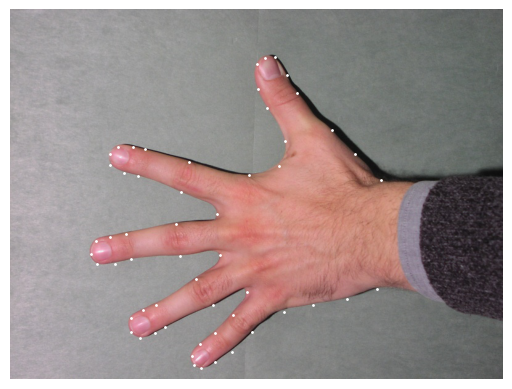

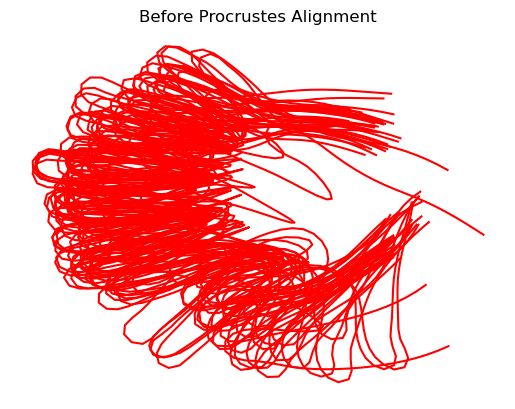

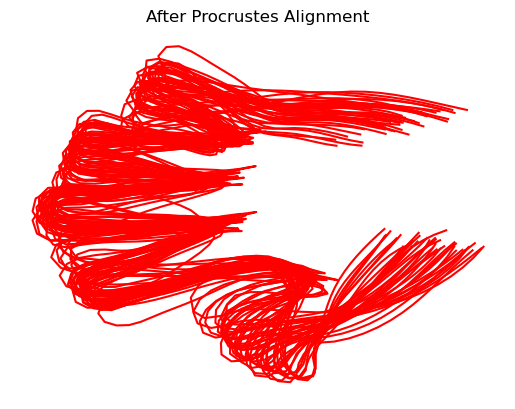

In [4]:
'''
main procedure
'''
filepath = './ssm_datasets/hand/all/shapes'
segmentationlist = readSegmentations(filepath,getxy)[0]
hands = np.array(segmentationlist).T

# show one example
showSegImg(os.path.join(filepath,'0000.jpg'),unmake_1d(hands[0]),600,600)

normalized_hands = procrustes_hand(hands)

mean_normalized_hand = np.mean(normalized_hands,axis = 0)


First 3 components contain approximately 90.2% of the variance!


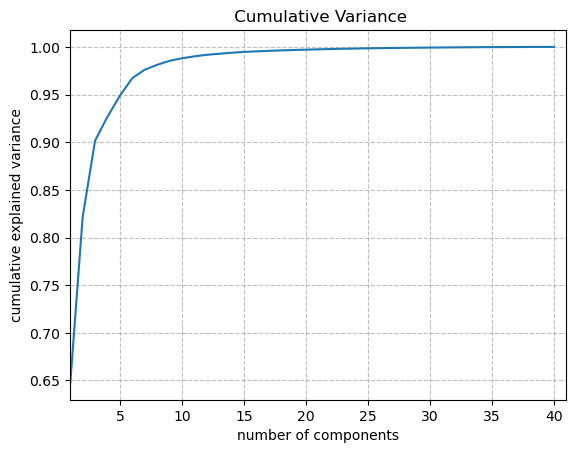

In [5]:
m = unmake_1d(mean_normalized_hand)
threshold = 0.9
# Compute and display cumulative Variance
# return the component number with cumulative variance >99.5%
compNum = showAccVar(normalized_hands, threshold)

# PCA function
pca = PCA(n_components=compNum)
pca.fit(normalized_hands)
hands_pca = pca.components_
hands_var = pca.explained_variance_

# print("original shape:   ", normalized_hands.shape)
# print("transformed shape:", hands_pca.shape)
# print(pca.explained_variance_)
# print(mean_normalized_hand.shape)



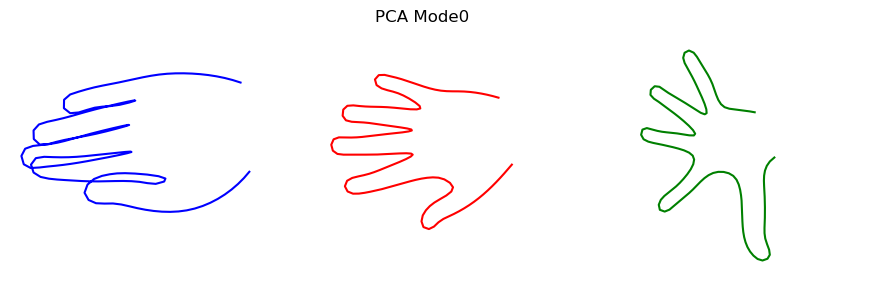

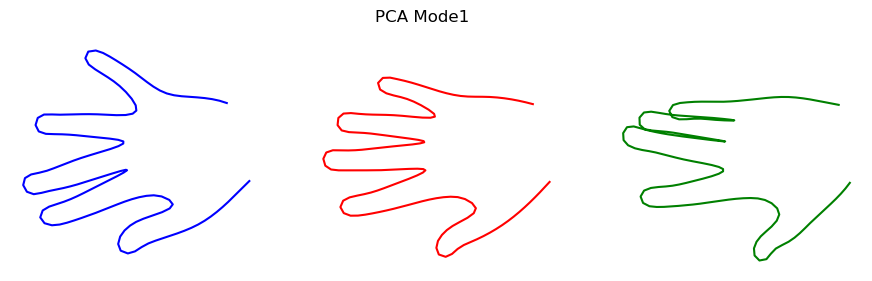

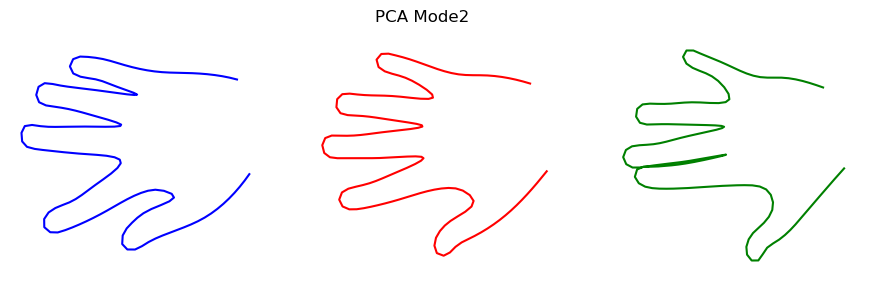

In [6]:
'''
static display

'''
#Static display of shape change
for i in range(compNum):
    modeminus = unmake_1d(hands_pca[i,:]*3*np.sqrt(hands_var[i])) + m
    modeplus = unmake_1d(hands_pca[i,:]* -3*np.sqrt(hands_var[i])) + m
    fig = plt.figure(figsize =(11,3))
    ax1 = plt.subplot(131)
    showInterp(interp(modeminus),marker = 'b')   
    plt.subplot(132,sharex = ax1, sharey = ax1)
    showInterp(interp(m))
    plt.subplot(133,sharex = ax1, sharey = ax1)
    showInterp(interp(modeplus),marker = 'g')
    plt.suptitle('PCA Mode' + str(i))
    plt.show()    

In [7]:
'''
dynamic display

'''
# Imports for JupyterLite
# %pip install -q ipywidgets matplotlib numpy scipy
%matplotlib inline
from ipywidgets import interact, interactive, FloatSlider
from IPython.display import clear_output, display, HTML
import numpy as np
from scipy import integrate
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import cnames
from matplotlib import animation

w = interactive(readinputs, NumOfstd = (-3., 3.), Mode=(0, 2))
display(w)

interactive(children=(FloatSlider(value=0.0, description='NumOfstd', max=3.0, min=-3.0), IntSlider(value=1, de…